   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 10.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sent_train.csv: 0.00B [00:00, ?B/s]

sent_valid.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/9543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2388 [00:00<?, ? examples/s]

Dataset cargado: zeroshot/twitter-financial-news-sentiment
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9543
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2388
    })
})
                                                text  label
0  $BYND - JPMorgan reels in expectations on Beyo...      0
1  $CCL $RCL - Nomura points to bookings weakness...      0
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3  $ESS: BTIG Research cuts to Neutral https://t....      0
4  $FNKO - Funko slides after Piper Jaffray PT cu...      0
label
2    6178
1    1923
0    1442
Name: count, dtype: int64


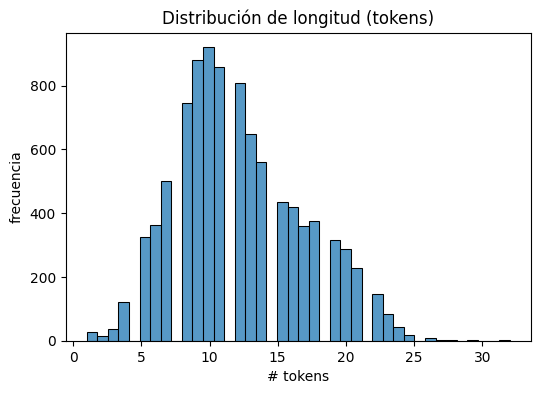

In [ ]:
# Instalaciones (Colab)
!pip -q install -U transformers datasets evaluate scikit-learn matplotlib seaborn wordcloud accelerate gensim umap-learn

import os, random, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

splits = {'train': 'sent_train.csv', 'validation': 'sent_valid.csv'}
# df = pd.read_csv("hf://datasets/zeroshot/twitter-financial-news-sentiment/" + splits["train"]) # aca cargamos el modelo preentrenado

import torch
from datasets import load_dataset

SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Carga del dataset financiero (EN)
def load_financial_news():
    ds = load_dataset("zeroshot/twitter-financial-news-sentiment")  # TODO: completar
    return ds, "zeroshot/twitter-financial-news-sentiment"        # TODO: completar

raw, source_name = load_financial_news()
print("Dataset cargado:", source_name)
print(raw)

# Normalizar a un DataFrame con columnas: text, label (0=Bearish, 1=Bullish, 2=Neutral)
def normalize_to_text_label(ds, source_name):
    split = "train" if "train" in ds else list(ds.keys())[0]
    df = ds[split].to_pandas()
    # heurísticas de nombre de columna de texto
    text_col_candidates = ["text", "tweet", "content", "sms", "sentence"]
    label_col_candidates = ["label", "labels", "target", "category"]

    text_col = next((c for c in text_col_candidates if c in df.columns), None)
    label_col = next((c for c in label_col_candidates if c in df.columns), None)

    if text_col is None:
        raise ValueError(f"No se encontró columna de texto en {df.columns.tolist()}")
    if label_col is None:
        raise ValueError(f"No se encontró columna de label en {df.columns.tolist()}")

    df = df[[text_col, label_col]].rename(columns={text_col: "text", label_col: "label"})

    # Labels ya son enteros 0/1/2 en este dataset; si fuesen strings, mapear
    if df["label"].dtype == object:
        # Mapear strings comunes
        mapping = {"bearish": 0, "bullish": 1, "neutral": 2}
        df["label"] = df["label"].map(lambda x: mapping.get(str(x).lower(), x))
    return df

df = normalize_to_text_label(raw, source_name)
df = df.dropna().reset_index(drop=True)

print(df.head())
print(df["label"].value_counts())

# Visualizaciones rápidas
df["length"] = df["text"].str.split().apply(len)
plt.figure(figsize=(6,4))
sns.histplot(df["length"], bins=40)
plt.title("Distribución de longitud (tokens)")
plt.xlabel("# tokens"); plt.ylabel("frecuencia")
plt.show()

¿Cómo es la distribución de longitudes? ¿Qué implica para el truncation del tokenizer?

¿Las clases están balanceadas? ¿Cómo afectará esto a las métricas y al entrenamiento?

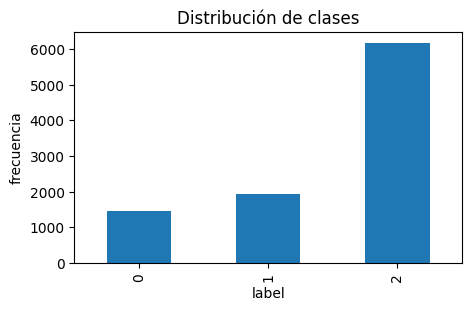


Top n-grams para clase 0:
co: 737
https co: 735
https: 735
to: 383
the: 321
in: 267
of: 233
on: 224
as: 175
after: 171

Top n-grams para clase 1:
co: 852
https: 842
https co: 842
to: 492
on: 387
the: 349
in: 324
up: 269
stock: 258
at: 215

Top n-grams para clase 2:
co: 3559
https: 3518
https co: 3518
the: 1892
to: 1787
of: 1255
in: 1058
for: 882
on: 762
and: 760


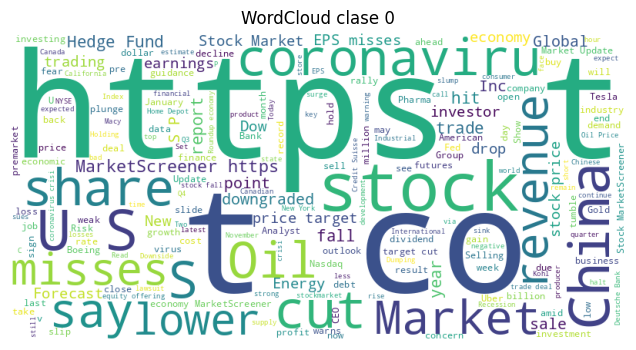

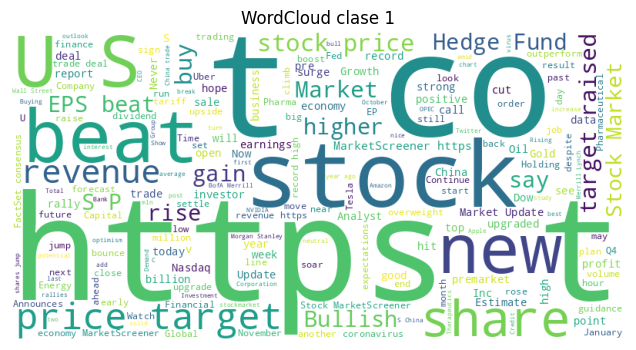

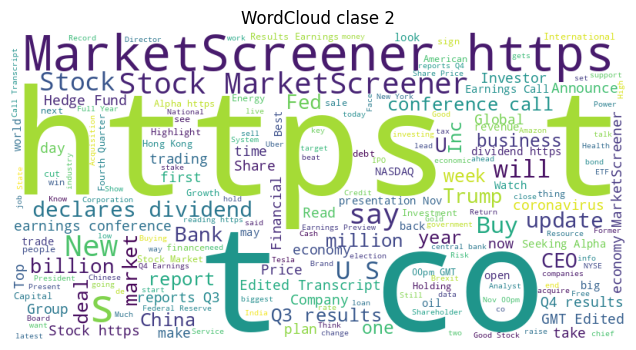

In [ ]:
# EDA adicional: distribución de clases
plt.figure(figsize=(5,3))
df["label"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribución de clases"); plt.xlabel("label"); plt.ylabel("frecuencia"); plt.show()

# Top n-grams por clase (BoW rápido)
from sklearn.feature_extraction.text import CountVectorizer
def top_ngrams_per_class(dataframe, label_col, text_col, ngram, topk):
    vec = CountVectorizer(max_features=100000, ngram_range=ngram)
    X = vec.fit_transform(dataframe[text_col])
    vocab = np.array(vec.get_feature_names_out())
    for label_value in sorted(dataframe[label_col].unique()):
        idx = (dataframe[label_col] == label_value).values
        counts = X[idx].sum(axis=0).A1
        top_idx = counts.argsort()[::-1][:topk]
        print(f"\nTop n-grams para clase {label_value}:")
        for token, c in zip(vocab[top_idx], counts[top_idx]):
            print(f"{token}: {c}")

top_ngrams_per_class(df, "label", "text", ngram=(1,2), topk=10)  # TODO: completar

# WordCloud por clase (si hay clases binarias/multiclase pequeñas)
from wordcloud import WordCloud
for label_value in sorted(df["label"].unique()):
    text_blob = " ".join(df.loc[df["label"] == label_value, "text"].astype(str).tolist())
    wc = WordCloud(width=800, height=400, background_color="white").generate(text_blob)
    plt.figure(figsize=(8,4)); plt.imshow(wc); plt.axis("off"); plt.title(f"WordCloud clase {label_value}"); plt.show()

¿Qué n‑grams son más frecuentes por clase? ¿Te sorprenden?
¿Qué sesgos/ruido ves en las nubes de palabras?

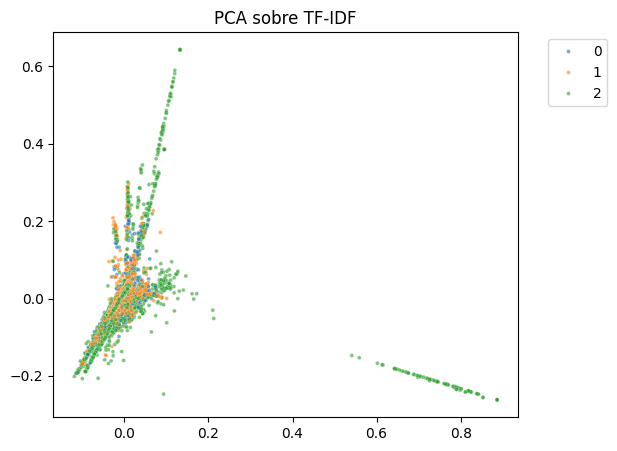

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


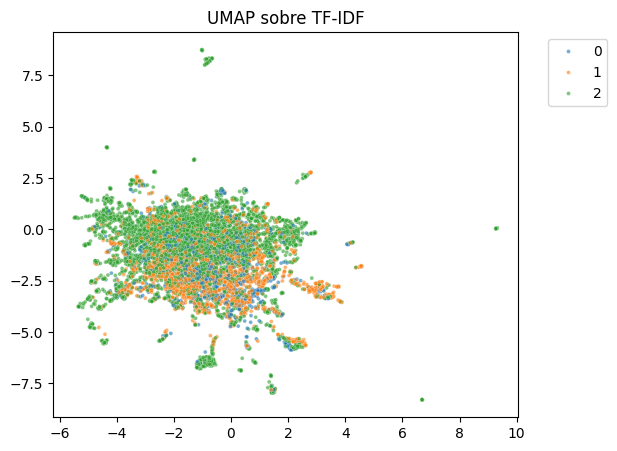

In [ ]:
# Proyección TF-IDF con PCA/UMAP para ver separabilidad
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import umap

tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2))
X = tfidf.fit_transform(df["text"])  # sparse

# PCA a 2D (aprox con truncated SVD si quisieras para sparse; aquí usamos .toarray() si cabe)
try:
    X_dense = X.toarray()
    pca = PCA(n_components=2, random_state=SEED)
    X_pca = pca.fit_transform(X_dense)
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df["label"], s=8, palette="tab10", alpha=0.6)
    plt.title("PCA sobre TF-IDF"); plt.legend(bbox_to_anchor=(1.05, 1), loc=2); plt.show()
except Exception:
    pass

# UMAP directamente desde sparse
reducer = umap.UMAP(n_components=2, random_state=SEED, metric="cosine")
X_umap = reducer.fit_transform(X)
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=df["label"], s=8, palette="tab10", alpha=0.6)
plt.title("UMAP sobre TF-IDF"); plt.legend(bbox_to_anchor=(1.05, 1), loc=2); plt.show()

# Word2Vec (exploratorio): vecinos más similares
from gensim.models import Word2Vec
sentences = [t.split() for t in df["text"].astype(str).tolist()]
w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=2, seed=SEED)
for probe in ["insulto", "mierda", "idiota", "respeto"]:
    if probe in w2v.wv:
        print(f"\nVecinos de '{probe}':")
        print(w2v.wv.most_similar(probe, topn=8))

¿Hay separabilidad en PCA/UMAP? Si no, ¿por qué? ¿Datos solapados, ruido, features?
¿Los vecinos de Word2Vec reflejan semántica financiera?

              precision    recall  f1-score   support

           0       0.59      0.64      0.61       288
           1       0.71      0.71      0.71       385
           2       0.88      0.86      0.87      1236

    accuracy                           0.80      1909
   macro avg       0.73      0.74      0.73      1909
weighted avg       0.80      0.80      0.80      1909



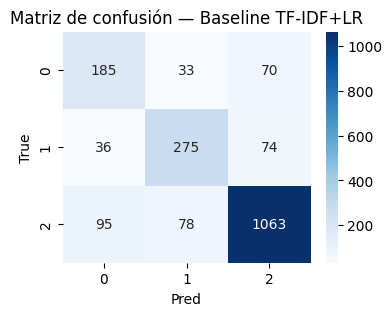

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"],
    test_size=0.2,             # TODO: 20% para test
    stratify=df["label"],      # TODO: Estratificar por el desbalance
    random_state=SEED          # TODO: Usar la semilla global
)

vectorizer = TfidfVectorizer(
    max_features=20000,        # TODO: Un vocabulario robusto
    ngram_range=(1, 2)         # TODO: Unigramas y Bigramas
)

clf = LogisticRegression(
    max_iter=1000,             # TODO: Más iteraciones para asegurar convergencia
    class_weight="balanced"    # ¡Clave para el desbalance de clases!
)

from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ("tfidf", vectorizer),
    ("lr", clf)
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusión — Baseline TF‑IDF+LR")
plt.xlabel("Pred"); plt.ylabel("True")
plt.show()

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict, ClassLabel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Preparar splits desde pandas (estratificación robusta)
train_df, test_df = train_test_split(
    df[["text", "label"]], test_size=0.2, stratify=df["label"], random_state=SEED
)

train_ds = Dataset.from_pandas(train_df).rename_column("label", "labels")
test_ds = Dataset.from_pandas(test_df).rename_column("label", "labels")

# Asegurar ClassLabel binario cuando es posible
try:
    train_ds = train_ds.cast_column("labels", ClassLabel(num_classes=3))
    test_ds = test_ds.cast_column("labels", ClassLabel(num_classes=3))
except Exception:
    pass

splits = DatasetDict({"train": train_ds, "test": test_ds})

# Modelo en inglés orientado a finanzas; fallback a modelos genéricos
checkpoint_candidates = [
    "bert-base-uncased",                   # TODO: alternativa 1 (genérico)
    "distilbert-base-uncased"              # TODO: alternativa 2 (genérico rápido)
]

def load_first_available_model(candidates):
    last_err = None
    for ck in candidates:
        try:
            tok = AutoTokenizer.from_pretrained(ck)
            mdl = AutoModelForSequenceClassification.from_pretrained(ck, num_labels=3)
            return ck, tok, mdl
        except Exception as e:
            last_err = e
    raise last_err

checkpoint, tokenizer, model = load_first_available_model(checkpoint_candidates)
print("Usando checkpoint:", checkpoint)

# Tokenización BPE: ejemplo rápido
samples = [
    "Esto es inaceptable y ofensivo.",
    "Gran trabajo del equipo, ¡excelente!"
]
for s in samples:
    toks = tokenizer.tokenize(s)
    print(f"\nTexto: {s}\nTokens: {toks}")

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

tokenized = splits.map(tokenize, batched=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    unique = np.unique(labels)
    avg = "binary" if len(unique) == 2 else "macro"
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average=avg)
    }

args = TrainingArguments(
    output_dir="outputs",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,                # TODO:
    per_device_train_batch_size=24,    # TODO: Batch size
    per_device_eval_batch_size=24,     # TODO: Batch size
    num_train_epochs=6,                # TODO:
    weight_decay=0.1,                 # TODO:
    logging_steps=20,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

trainer.train()
results = trainer.evaluate()
print(results)

Casting the dataset:   0%|          | 0/7634 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1909 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Usando checkpoint: bert-base-uncased

Texto: Esto es inaceptable y ofensivo.
Tokens: ['est', '##o', 'es', 'ina', '##ce', '##pta', '##ble', 'y', 'of', '##ens', '##ivo', '.']

Texto: Gran trabajo del equipo, ¡excelente!
Tokens: ['gran', 'tr', '##aba', '##jo', 'del', 'e', '##qui', '##po', ',', '¡', 'excel', '##ente', '!']


Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

/tmp/ipython-input-4078179735.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 90_postal-subpagina (90_postal-subpagina-universidad-cat-lica-del-uruguay) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.540500,0.420331,0.844421,0.790965
2,0.316400,0.376327,0.860136,0.821228
3,0.155900,0.486282,0.851231,0.812291
4,0.113100,0.561664,0.861708,0.822166
5,0.082000,0.653526,0.865375,0.824702
6,0.020100,0.687525,0.868518,0.826542


{'eval_loss': 0.687524676322937, 'eval_accuracy': 0.8685175484546883, 'eval_f1': 0.82654230597324, 'eval_runtime': 7.8989, 'eval_samples_per_second': 241.681, 'eval_steps_per_second': 10.128, 'epoch': 6.0}


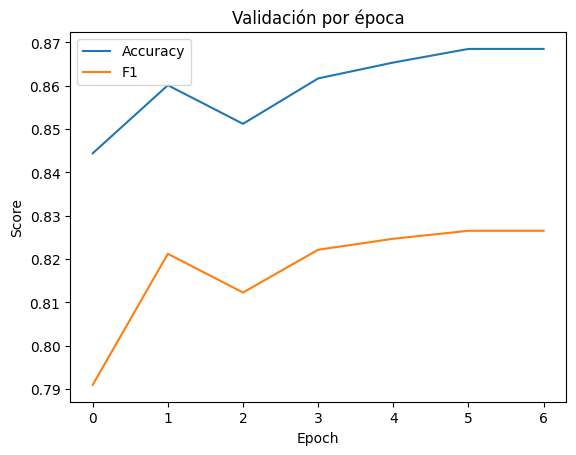

{'baseline': {'acc': 0.7977998952331063, 'f1': 0.7320611871573899}, 'transformer': {'acc': 0.8685175484546883, 'f1': 0.82654230597324}}


In [ ]:
# Curvas de métricas por época (si están en el state log)
hist = trainer.state.log_history
acc = [x['eval_accuracy'] for x in hist if 'eval_accuracy' in x]
f1s = [x['eval_f1'] for x in hist if 'eval_f1' in x]

plt.plot(acc, label="Accuracy")
plt.plot(f1s, label="F1")
plt.title("Validación por época")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.legend(); plt.show()

# Comparación simple Baseline vs Transformer
from sklearn.metrics import f1_score, accuracy_score
y_pred_base = pipe.predict(X_test)
base_acc = accuracy_score(y_test, y_pred_base)
base_f1 = f1_score(y_test, y_pred_base, average=("binary" if len(np.unique(y_test))==2 else "macro"))

preds_logits = trainer.predict(tokenized["test"]).predictions
y_pred_tr = preds_logits.argmax(axis=-1)
tr_acc = accuracy_score(tokenized["test"]["labels"], y_pred_tr)
tr_f1 = f1_score(tokenized["test"]["labels"], y_pred_tr, average=("binary" if len(np.unique(tokenized["test"]["labels"]))==2 else "macro"))

print({"baseline": {"acc": base_acc, "f1": base_f1}, "transformer": {"acc": tr_acc, "f1": tr_f1}})

In [ ]:
# --- Inicio del Código para Extensión 1 ---

print("\n--- Iniciando Extensión 1: Probando ProsusAI/finbert ---")

# 1. Definir los candidatos, esta vez con 'finbert' primero
checkpoint_candidates = [
    "ProsusAI/finbert",                    # ¡El modelo específico de finanzas!
    "bert-base-uncased",                   # Fallback genérico
]

# 2. Cargar el modelo (la función 'load_first_available_model' es la misma)
checkpoint, tokenizer, model = load_first_available_model(checkpoint_candidates)
print("Usando checkpoint para Extensión 1:", checkpoint)

# 3. Tokenizar los datos (el 'tokenized' DatasetDict es el mismo)
# No es necesario volver a ejecutar: tokenized = splits.map(tokenize, batched=True)

# 4. Definir nuevos TrainingArguments
args_finbert = TrainingArguments(
    output_dir="outputs-finbert",      # Directorio de salida diferente
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,                # Misma LR
    per_device_train_batch_size=24,    # Mismo batch size
    per_device_eval_batch_size=24,     # Mismo batch size
    num_train_epochs=3,                # MENOS épocas, esperamos que aprenda más rápido
    weight_decay=0.01,                 # Regularización (en lugar de 0.1 que usaste)
    logging_steps=20,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

# 5. Crear un nuevo Trainer
trainer_finbert = Trainer(
    model=model,
    args=args_finbert,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    compute_metrics=compute_metrics,   # La función 'compute_metrics' es la misma
    tokenizer=tokenizer
)

# 6. Entrenar y Evaluar
trainer_finbert.train()
results_finbert = trainer_finbert.evaluate()

print("\nResultados del Baseline (bert-base-uncased, mejor época):")
print(f"F1-macro: {tr_f1:.4f}")

print("\nResultados de FinBERT (ProsusAI/finbert):")
print(results_finbert)

# 7. Comparación final
print("\n--- Comparativa Final ---")
print(f"Baseline (TF-IDF):     {base_f1:.4f} F1-macro")
print(f"Genérico (BERT-base):  {tr_f1:.4f} F1-macro")
print(f"Dominio (FinBERT):     {results_finbert['eval_f1']:.4f} F1-macro")

# --- Fin del Código para Extensión 1 ---


--- Iniciando Extensión 1: Probando ProsusAI/finbert ---


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Usando checkpoint para Extensión 1: ProsusAI/finbert


/tmp/ipython-input-3111243639.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_finbert = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.521000,0.421573,0.841802,0.771660
2,0.306700,0.392005,0.866422,0.818675
3,0.164100,0.448672,0.865375,0.821597



Resultados del Baseline (bert-base-uncased, mejor época):
F1-macro: 0.8265

Resultados de FinBERT (ProsusAI/finbert):
{'eval_loss': 0.44867202639579773, 'eval_accuracy': 0.8653745416448402, 'eval_f1': 0.8215965838158249, 'eval_runtime': 7.922, 'eval_samples_per_second': 240.974, 'eval_steps_per_second': 10.098, 'epoch': 3.0}

--- Comparativa Final ---
Baseline (TF-IDF):     0.7321 F1-macro
Genérico (BERT-base):  0.8265 F1-macro
Dominio (FinBERT):     0.8216 F1-macro



--- Iniciando Extensión 2: Visualizando Embeddings del Transformer ---


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


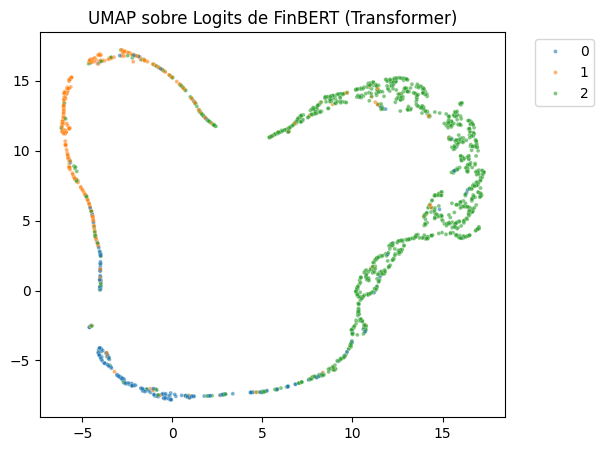

In [ ]:
# --- Inicio del Código para Extensión 2: Visualizar Embeddings ---
import umap
import torch

print("\n--- Iniciando Extensión 2: Visualizando Embeddings del Transformer ---")

# 1. Obtener las predicciones (que incluyen los logits y embeddings ocultos si se configuran)
#    Para este caso, usaremos los logits (la capa justo antes de la predicción)
#    extraídos del 'test' dataset.
test_predictions = trainer_finbert.predict(tokenized["test"])
logits = test_predictions.predictions

# 2. Obtener las etiquetas verdaderas
labels = tokenized["test"]["labels"]

# 3. Aplicar UMAP sobre los logits
#    Los logits son una representación de alta dimensionalidad de lo que el modelo "piensa"
reducer = umap.UMAP(n_components=2, random_state=SEED, metric="cosine")
X_umap_transformer = reducer.fit_transform(logits)

# 4. Graficar
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_umap_transformer[:,0], y=X_umap_transformer[:,1], hue=labels, s=8, palette="tab10", alpha=0.6)
plt.title("UMAP sobre Logits de FinBERT (Transformer)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);
plt.show()

# --- Fin del Código para Extensión 2 ---

In [ ]:
# --- Inicio del Código para Extensión 3 (CORREGIDO) ---
from sklearn.utils.class_weight import compute_class_weight
from transformers import Trainer
import torch.nn as nn
import torch

print("\n--- Iniciando Extensión 3: Balanceo de Clases en Transformer ---")

# 1. Calcular los pesos de clase
train_labels = tokenized["train"]["labels"]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(model.device)
print(f"Pesos de clase calculados: {class_weights}")

# 2. Crear un Trainer personalizado que use los pesos
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs): # <-- ¡CORRECCIÓN APLICADA!
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# 3. Cargar el modelo base FinBERT (para un entrenamiento limpio)
print("Cargando modelo FinBERT para re-entrenar con balanceo...")
checkpoint_finbert = "ProsusAI/finbert"
model_balanced = AutoModelForSequenceClassification.from_pretrained(checkpoint_finbert, num_labels=3)
tokenizer_balanced = AutoTokenizer.from_pretrained(checkpoint_finbert)

# 4. Crear la instancia del NUEVO Trainer (WeightedTrainer)
#    (Reusamos los 'args_finbert' de la Extensión 1)
trainer_balanced = WeightedTrainer(
    model=model_balanced,
    args=args_finbert, # Reusamos los args (3 épocas, etc.)
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer_balanced
)

# 5. Entrenar y Evaluar
print("Entrenando con balanceo de clases...")
trainer_balanced.train()
results_balanced = trainer_balanced.evaluate()

# 6. Comparativa Final Absoluta
print("\n--- Comparativa Final Absoluta ---")
print(f"Baseline (TF-IDF + Balanced):     {base_f1:.4f} F1-macro")
print(f"Genérico (BERT-base):             {tr_f1:.4f} F1-macro")
print(f"Dominio (FinBERT - Sin Balanceo): {results_finbert['eval_f1']:.4f} F1-macro")
print(f"Dominio (FinBERT + Balanced):     {results_balanced['eval_f1']:.4f} F1-macro")

# --- Fin del Código para Extensión 3 ---


--- Iniciando Extensión 3: Balanceo de Clases en Transformer ---
Pesos de clase calculados: [2.20508377 1.65452969 0.51490625]
Cargando modelo FinBERT para re-entrenar con balanceo...


/tmp/ipython-input-3442614560.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer_balanced = WeightedTrainer(


Entrenando con balanceo de clases...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.624400,0.509303,0.841802,0.792767
2,0.384700,0.458339,0.854898,0.814229
3,0.191300,0.508994,0.859612,0.819571



--- Comparativa Final Absoluta ---
Baseline (TF-IDF + Balanced):     0.7321 F1-macro
Genérico (BERT-base):             0.8265 F1-macro
Dominio (FinBERT - Sin Balanceo): 0.8216 F1-macro
Dominio (FinBERT + Balanced):     0.8196 F1-macro
